# Tunax benchmark on Wagner LES
The purpose of this notebook is to make benchmark on some new Tunax implementations to check the gain in terms of runtimes, for direct model and gradient of the model. For this we use a LES database done by Gregory Wagner.

## Global imports

In [1]:
import os
import shutil
import requests
import zipfile
import warnings
from typing import List, Tuple, TypeAlias, Dict
from time import time as tt
from dataclasses import replace

import equinox as eqx
import jax.numpy as jnp
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib.pyplot import Figure, Axes
from jax import block_until_ready, grad, jacfwd, jit

warnings.filterwarnings("ignore", category=UserWarning)

subplot_0D_type: TypeAlias = Tuple[Figure, Axes]
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
latex_installed = shutil.which("latex") is not None
plt.rcParams.update({
    'text.usetex': latex_installed,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 15
})

## Device
Change the next cell to define the device that you are using for the runtimes benchmark.

In [2]:
DEVICE = 'apple_M3pro'

## Wagner's LES
The data is available at the [Wagner's calibration repository](https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file).

### Download

In [3]:
do_run = False
if do_run:
    url = 'https://www.dropbox.com/scl/fi/8qwe9hf6wxc3w0crhzpml/profiles.zip?rlkey=sm8f7rhfokitzc7cgwinhip2k'
    url = url + '&dl=1'
    archive_file_name = 'tmp.zip'
    response = requests.get(url, allow_redirects=True)
    with open(archive_file_name, 'wb') as file:
        file.write(response.content)
    with zipfile.ZipFile(archive_file_name, 'r') as zipf:
        zipf.extractall()
    os.remove(archive_file_name)

### Global variables
Descriptions of the Wagner's LES database.

In [4]:
LES_TIMEFRAMES = [6, 12, 24, 48, 72]
LES_SPACE_STEPS = [1, 2, 4]
LES_FORCINGS = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]
N_LES_T = len(LES_TIMEFRAMES)
N_LES_S = len(LES_SPACE_STEPS)
N_LES_F = len(LES_FORCINGS)

# link between Wagner's and Tunax names of the variables
LES_VAR_NAMES = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

# on which dimensions load the variables
LES_DIMS = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

LES_PATH = 'Wagner_LES'

NOTEBOOK_DATA_PATH = 'data'
os.makedirs(NOTEBOOK_DATA_PATH, exist_ok=True)

### Rename folders and file

In [5]:
do_run = False
if do_run:
    os.rename('profiles', LES_PATH)
    for timeframe in LES_TIMEFRAMES:
        os.rename(os.path.join(LES_PATH, f'{timeframe}_hour_suite'), os.path.join(LES_PATH, f'{timeframe}h'))
        for space_step in LES_SPACE_STEPS:
            for forcing in LES_FORCINGS:
                os.rename(
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2'),
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                )
    os.remove(os.path.join(LES_PATH, 'getsuite.sh'))

### Forcings
Described in [this paper](https://doi.org/10.48550/arXiv.2306.13204).

In [6]:
def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

# New *Tunax*'s implementations
## List of experiments tested
For the benchmark on the gradients, we will try several experiences with the new implementations.

### `tunax_default`
Here we use the function `grad` one with the default Tunax implementation (which contains some *jitted* functions inside the loop). It's this version which was way too slow to be able to do a proper calibration run. The step function is jitted here. And there is also a jit on the $k-\varepsilon$ function.

### `tridiag_scan`
Here it's the same but we just change the tridiagonal inversion function using `lax.scan`, there is still a `jit` on the step function as in Tunax default implementation. These implementation and the following are in the folder `tunax_new/`.

### `temporal_loop_scan`
Here we wrote the temporal integration loop with `lax.scan`. It is composed of an inner loop for doing the steps between every output, and an outer loop to loop on all these outputs states. The step function is jitted. 

### `jit_outside`
The same as before but we jitted the whole model run function (which implies to make some modifications on the classes to make some attributes statics).

### `no_intermediate_outputs`
Here we wrote the temporal integraction loop with `lax.scan`, and we use a function that only returns the last state of the simulation, we can expect that it would be faster as JAX has less data to work with. Everything is jitted again.

### `array_forcings`
Here is a new version of Tunax where we define the forcings of the tracers as arrays and not as functions, it should reduce the number of compilations when we use it in various cases. We modified more the classes that we had to do another source folder in `tunax_new_case_tracable/`. The whole model run function is jitted.

# Runs directs
## Experience descriptions
Here we describe the experiences corresponding to the new implementations just described

In [7]:
direct_experiences = {
    'tunax_default': {
        'name': 'tunax_default',
        'tunax_version': 'tunax',
        'run_method_name': 'compute_trajectory_with',
        'output': 'trajectory',
        'jitted_method': False
    },
    'tridiag_scan': {
        'name': 'tridiag_scan',
        'tunax_version': 'tunax_new',
        'run_method_name': 'compute_trajectory_with',
        'output': 'trajectory',
        'jitted_method': False
    },
    'temporal_loop_scan': {
        'name': 'temporal_loop_scan',
        'tunax_version': 'tunax_new',
        'run_method_name': 'run_jit_step',
        'output': 'trajectory',
        'jitted_method': False
    },
    'jit_outside': {
        'name': 'jit_outside',
        'tunax_version': 'tunax_new',
        'run_method_name': 'jit_run',
        'output': 'trajectory',
        'jitted_method': True
    },
    'no_intermediate_outputs': {
        'name': 'no_intermediate_outputs',
        'tunax_version': 'tunax_new',
        'run_method_name': 'jit_run_final_state',
        'output': 'final_state',
        'jitted_method': True
    },
    'array_forcings': {
        'name': 'array_forcings',
        'tunax_version': 'tunax_new_case_tracable',
        'run_method_name': 'jit_run',
        'output': 'trajectory',
        'jitted_method': True
    }
}

## Benchmark function
This function runs all the 105 cases of the Wagner's LES, for one experiences that we just describe, and this for some number of trials. The output of all the simulations are written in NetCDF files, and the runtimes are recorded. Futhermore, we record if the function of total run (when it is a jitted function) is compilated again.

In [8]:
from tunax import SingleColumnModel as ModelOld
from tunax import Obs as ObsOld
from tunax.closures import KepsParameters as KepsParOld
from tunax_new import SingleColumnModel as ModelNew
from tunax_new import Obs as ObsNew
from tunax_new.closures import KepsParameters as KepsParNew
from tunax_new_case_tracable import SingleColumnModel as ModelNewTracable
from tunax_new_case_tracable import Obs as ObsNewTracable
from tunax_new_case_tracable.closures import KepsParameters as KepsParNewTracable

def benchmark_direct(n_trials: int, dt: float, experience: dict):
    # files
    runtimes = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials))
    compilations = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials), dtype=bool)
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience['name'])
    runtimes_path = os.path.join(output_path, f'runtimes_{DEVICE}.npy')
    compilations_path = os.path.join(output_path, f'compilations_{DEVICE}.npy')
    os.makedirs(output_path, exist_ok=True)

        # select good classes

    tunax_version = experience['tunax_version']
    match tunax_version:
        case 'tunax':
            ObsClass = ObsOld
            KepsParClass = KepsParOld
        case 'tunax_new':
            ObsClass = ObsNew
            KepsParClass = KepsParNew
        case 'tunax_new_case_tracable':
            ObsClass = ObsNewTracable
            KepsParClass = KepsParNewTracable

    # loop on all timeframe, space steps and forcing
    old_cache_size = 0
    pbar = tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES)*len(LES_FORCINGS), desc=experience['name'])
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_forcing, forcing in enumerate(LES_FORCINGS):
                jld2_filename = os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                traj_output_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
                os.makedirs(os.path.dirname(traj_output_path), exist_ok = True)
                obs = ObsClass.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

                # case corrections
                obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
                new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
                obs = eqx.tree_at(lambda t: t.case, obs, new_case)
                obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

                # passive tracer forcing
                omega_p = 1/obs.metadatas['pt_timescale']
                lambda_c = obs.metadatas['pt_width']
                zc = obs.metadatas['pt_depth']
                l_z = obs.trajectory.grid.hbot
                wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
                new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
                if tunax_version != 'tunax_new_case_tracable':
                    new_case = replace(new_case, pt_forcing_type='constant')
                obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                # sunny forcing
                if forcing == 'strong_wind_and_sunny':
                    jb = obs.metadatas['sunny_flux']
                    eps1 = 0.6
                    lambda1 = 1.
                    lambda2 = 16.
                    wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                    new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
                    if tunax_version != 'tunax_new_case_tracable':
                        new_case = replace(new_case, b_forcing_type='constant')
                    obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                # model instance
                traj_wagner = obs.trajectory
                init_state = traj_wagner.extract_state(0)
                match tunax_version:
                    case 'tunax':
                        timeframe_h = float(traj_wagner.time[-1]/3600)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        model = ModelOld(timeframe_h, dt, out_dt, init_state, obs.case, 'k-epsilon')
                    case 'tunax_new':
                        nt = int(timeframe*3600/dt)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        p_out = int(out_dt/dt)
                        model = ModelNew(nt, dt, p_out, init_state, obs.case, 'k-epsilon')
                    case 'tunax_new_case_tracable':
                        nt = int(timeframe*3600/dt)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        p_out = int(out_dt/dt)
                        model = ModelNewTracable(nt, dt, p_out, init_state, obs.case, 'k-epsilon')

                # k-epsilon parameters
                keps_params = KepsParClass()

                # run gradient for several trials
                for i_trial in tqdm(range(n_trials), desc='trials', leave=False):
                    # run the model
                    run_method = getattr(model, experience['run_method_name'])
                    start_time = tt()
                    output = block_until_ready(run_method(keps_params))
                    runtimes[i_space_step, i_timeframe, i_forcing, i_trial] = tt() - start_time

                    # record the compilation
                    if experience['jitted_method']:
                        if run_method._cache_size() > old_cache_size:
                            compilations[i_space_step, i_timeframe, i_forcing, i_trial] = True
                            old_cache_size = run_method._cache_size()

                    # write the times and the cache size
                    np.save(runtimes_path, runtimes)
                    np.save(compilations_path, compilations)
                
                # write the output
                if tunax_version == 'tunax':
                    ds = output.to_ds()
                    ds.to_netcdf(traj_output_path)
                else:
                    output.to_nc(traj_output_path)


                pbar.update(1)
    pbar.close()

## Run all benchmarks

In [9]:
do_run = False

n_trials = 5
dt = 10.

if do_run:
    for experience in direct_experiences.values():
        benchmark_direct(n_trials, dt, experience)

The run took 97 minutes on a Macbook Pro with an Apple M3Pro CPU.

## Checking the results and consistency of new implementations
### Plot function
This function plots for one timeframe and one time step value, all the forcings in their last states for the database and the model, for buoyancy, velocities and passive tracer.

In [10]:
from tunax import Obs

titles_forcing = {

    'free_convection': 'free convection',
    'weak_wind_strong_cooling': 'weak wind\nstrong cooling',
    'med_wind_med_cooling': 'med wind\nmed cooling',
    'strong_wind_weak_cooling': 'strong wind\nweak cooling',
    'strong_wind': 'strong wind',
    'strong_wind_no_rotation': 'strong wind\nno rotation',
    'strong_wind_and_sunny': 'strong wind sunny\n no rotation'
}

def plot_wag(timeframe: int, space_step: int, experience: dict):
    # figure
    sp: subplot_2D_type = plt.subplots(3, 7, sharey=True, figsize=(18, 12))
    _, [axs_b, axs_uv, axs_pt] = sp

    for i_forcing, forcing in enumerate(LES_FORCINGS):
        # read data
        filename = os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
        wagner_obs = Obs.from_jld2(filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory
        output_path = os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience['name'])
        tunax_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)

        # get last state
        wagner_init_state = wagner_traj.extract_state(0)
        wagner_last_state = wagner_traj.extract_state(-1)
        if experience['output'] == 'trajectory':
            tunax_last_state_dict = {tracer: tunax_ds[tracer][-1, :] for tracer in ['b', 'u', 'v',  'pt']}
        elif experience['output'] == 'final_state':
            tunax_last_state_dict = {tracer: tunax_ds[tracer] for tracer in ['b', 'u', 'v',  'pt']}
        zr = wagner_init_state.grid.zr
        
        # plots buoyancy
        axs_b[i_forcing].plot(wagner_init_state.b, zr, 'k', linewidth=1)
        axs_b[i_forcing].plot(wagner_last_state.b, zr, 'r')
        axs_b[i_forcing].plot(tunax_last_state_dict['b'], zr, 'g')

        # plot velocities
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_init_state.u, zr, 'k', linewidth=1)
            axs_uv[i_forcing].plot(wagner_last_state.u, zr, 'r')
            axs_uv[i_forcing].plot(tunax_last_state_dict['u'], zr, 'g')
            axs_uv[i_forcing].plot(wagner_init_state.v, zr, 'k--', linewidth=1)
            axs_uv[i_forcing].plot(wagner_last_state.v, zr, 'r--')
            axs_uv[i_forcing].plot(tunax_last_state_dict['v'], zr, 'g--')

        # plot passive trace
        axs_pt[i_forcing].plot(wagner_init_state.pt, zr, 'k', linewidth=1)
        axs_pt[i_forcing].plot(wagner_last_state.pt, zr, 'r')
        axs_pt[i_forcing].plot(tunax_last_state_dict['pt'], zr, 'g')
        
        # forcing title
        axs_b[i_forcing].set_title(titles_forcing[LES_FORCINGS[i_forcing]])
    
    # axis names
    axs_b[0].set_ylabel(r'$b []$')
    axs_uv[1].set_ylabel(r'$u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    axs_pt[0].set_ylabel(r'passive tracer $[]$')

    # legend
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].legend(loc='lower center')

    # limits
    axs_b[0].set_ylim(-200, 2)

    # axis off
    axs_uv[0].axis('off')

    # additional text
    axs_uv[0].text(-0.0, -40, f'time = {timeframe}h\nspace step = {space_step}m\n{experience['name']}', fontsize=18, horizontalalignment='center')

### Plots for all new methods
For a timeframe of 24h and 1m of time step.

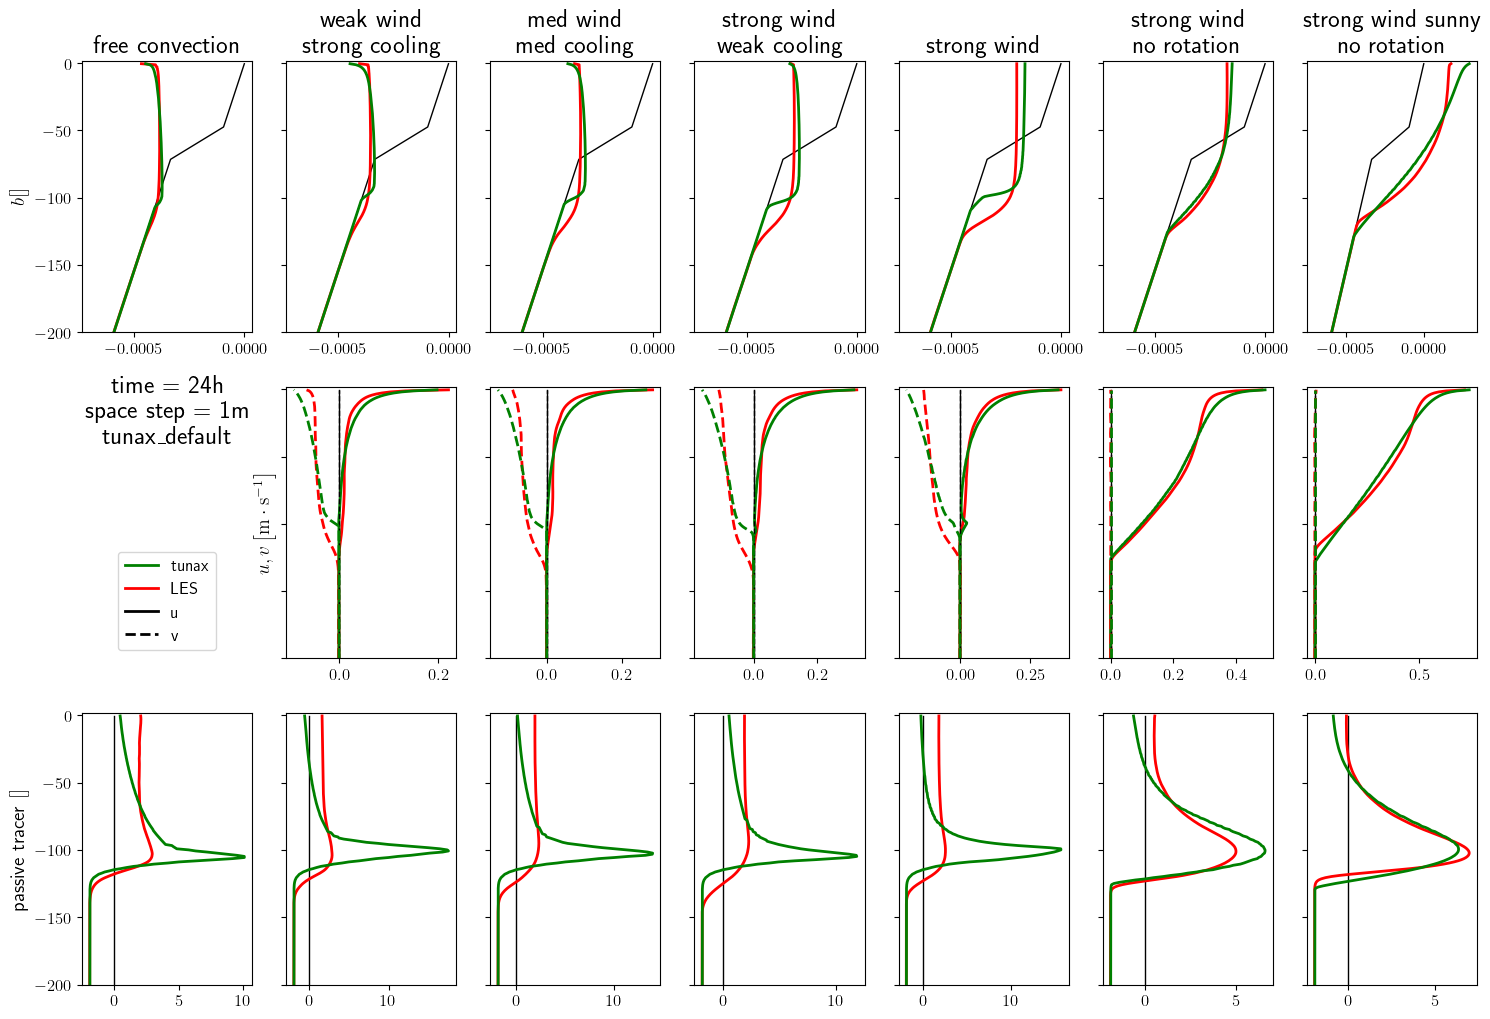

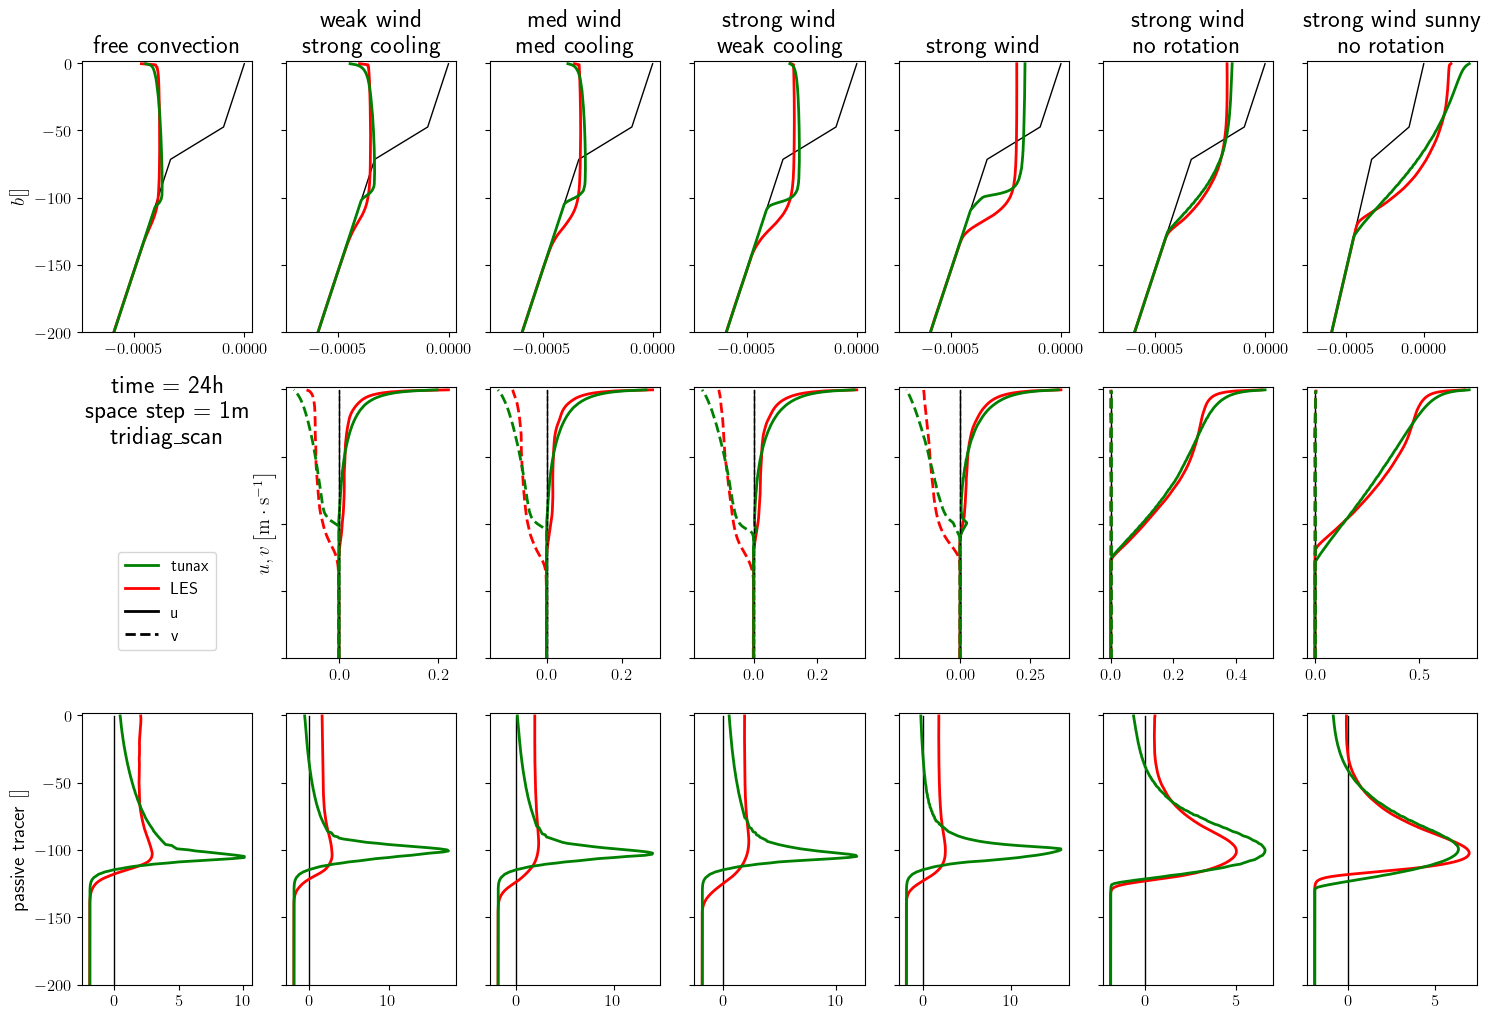

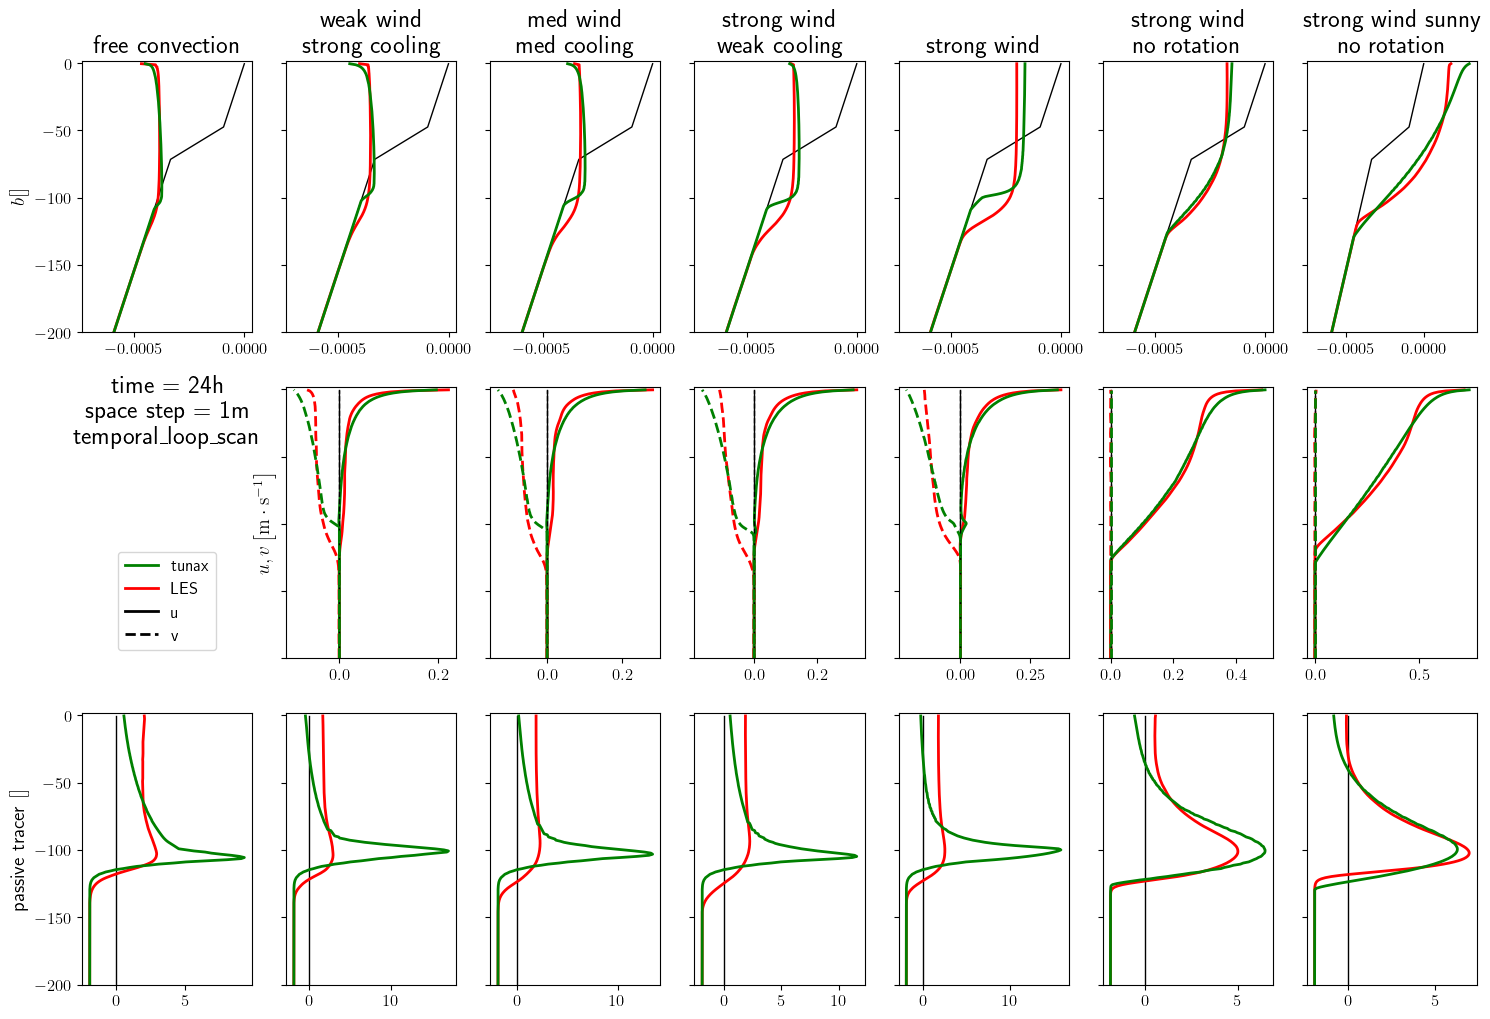

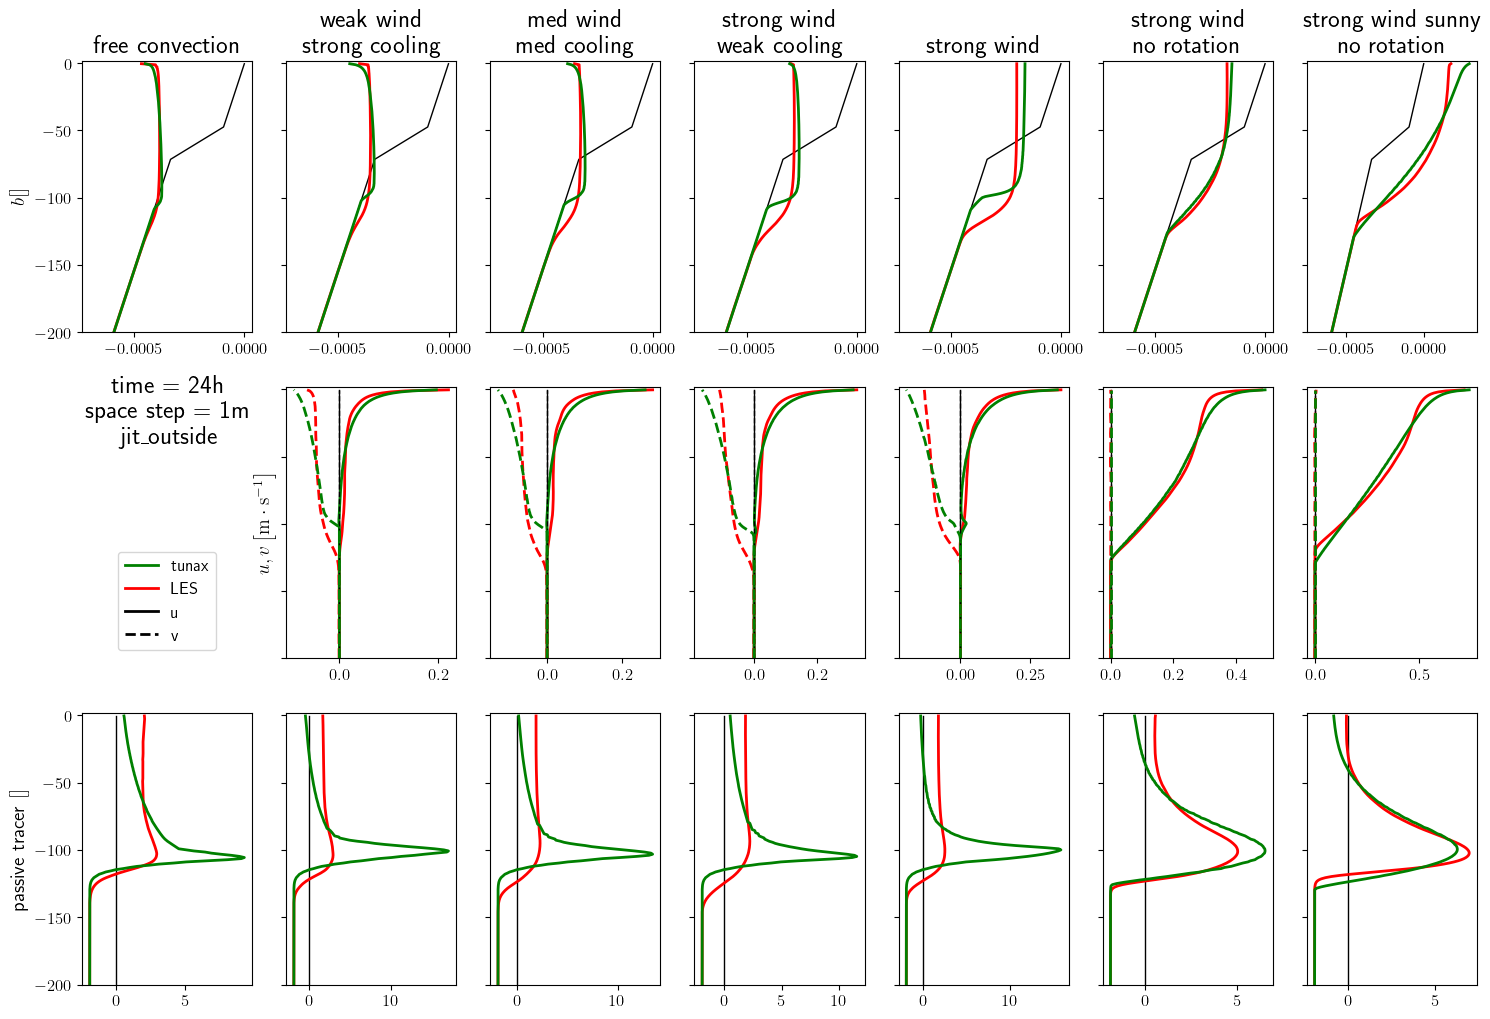

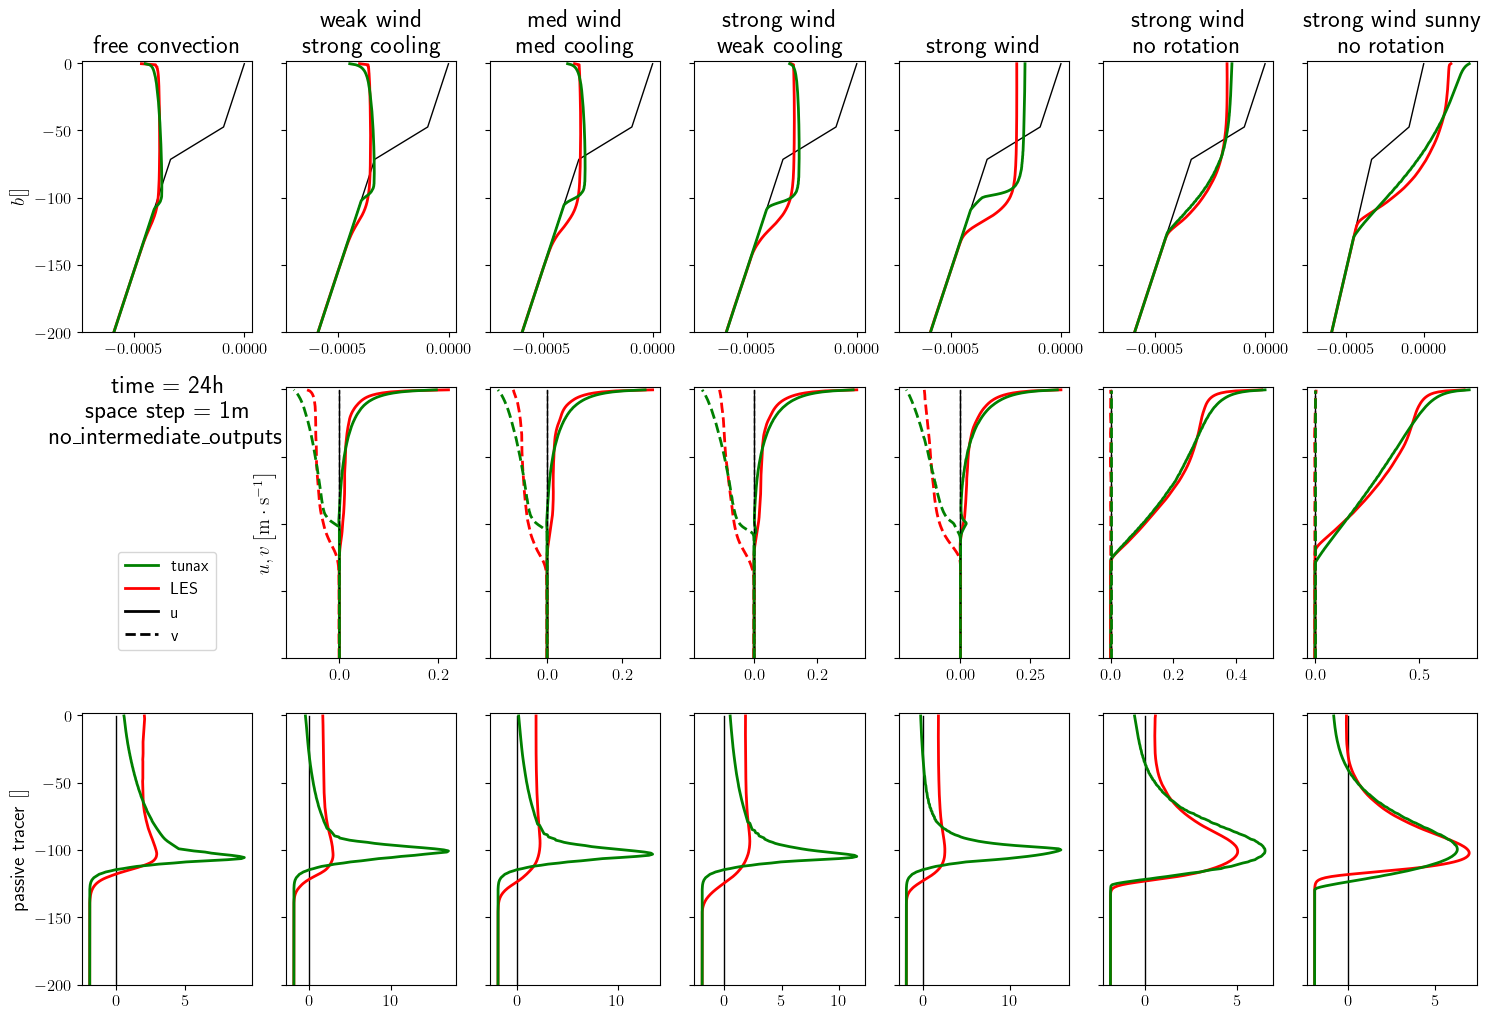

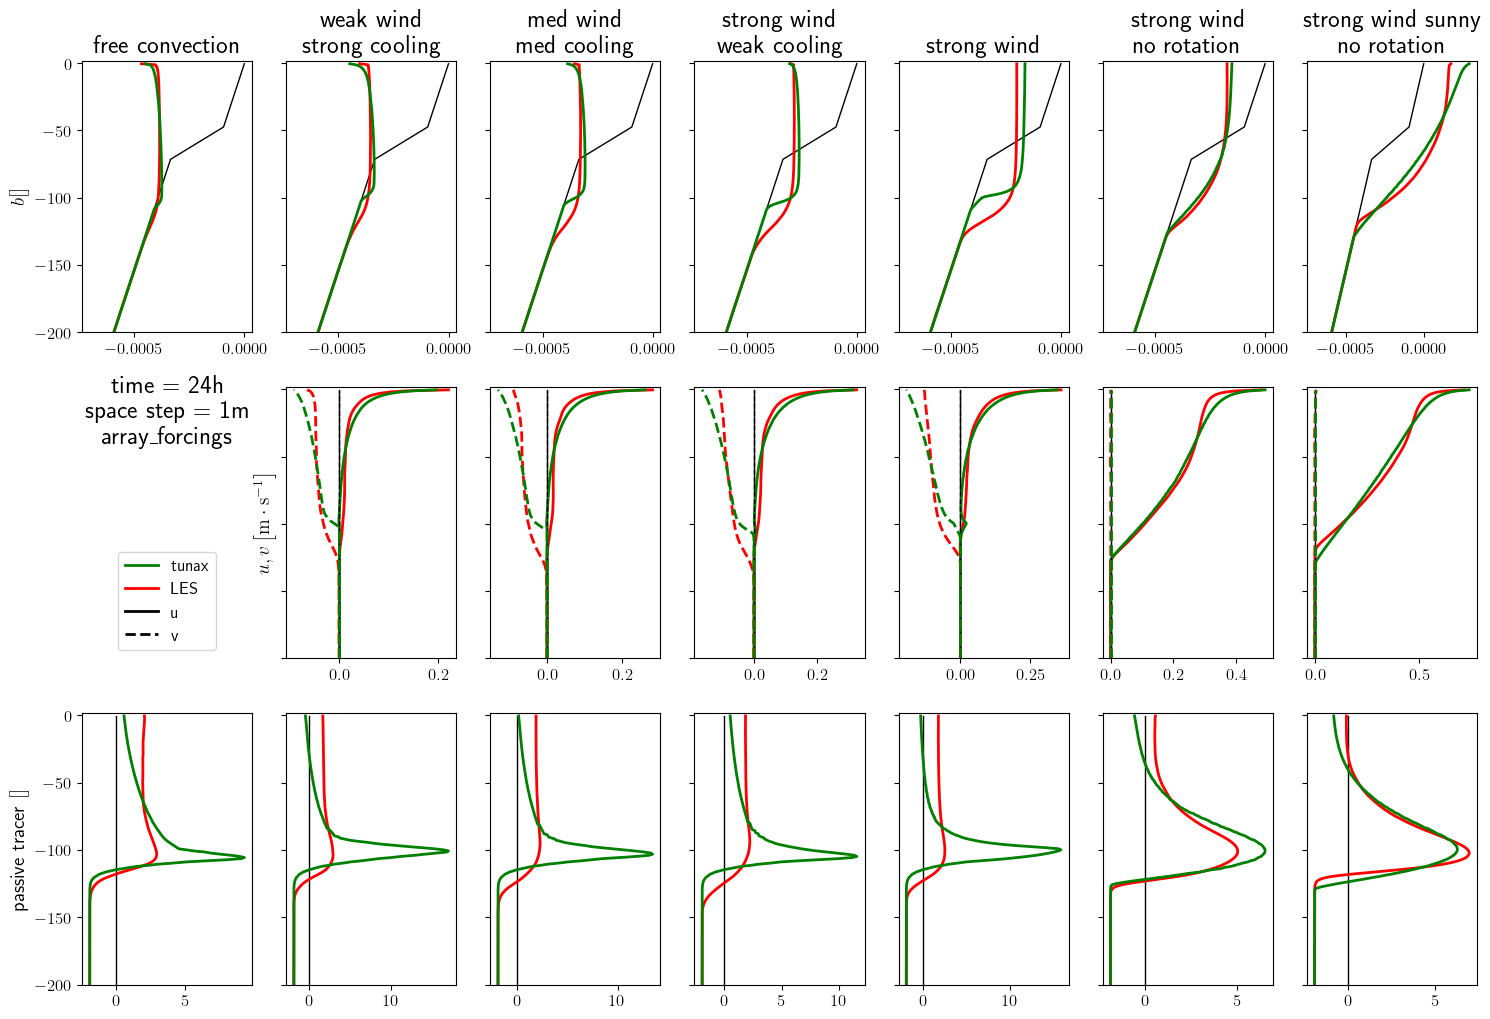

In [11]:
do_plot = True

timeframe = 24
space_step = 1

if do_plot:
    for experience in direct_experiences.values():
        plot_wag(timeframe, space_step, experience)

We observe that for all the new implementations, the outputs ar correct.

## Runtimes
### Load datas

In [12]:
runtimes_file_name = f'runtimes_{DEVICE}.npy'
compilations_file_name = f'compilations_{DEVICE}.npy'
runtimes_by_experience = {experience: np.load(os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience, runtimes_file_name)) for experience in direct_experiences.keys()}
compilations_by_experience = {experience: np.load(os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience, compilations_file_name)) for experience in direct_experiences.keys()}

### Compilation effect and forcing comparisons
#### Plot function
This function plots the runtimes of the runs in the order of their execution. The purpose is to see the effect of jitification.

In [13]:
def plot_comp_direct(timeframe: int, space_step: int):
    # plot parameters
    cmap = mpl.colormaps['Set1']
    color_comp = 'b'

    # figure
    sp: subplot_2D_type = plt.subplots(3, 3, figsize=(15, 10), width_ratios=(1, 1, .5), height_ratios=(1, 1, 1))
    fig, axes_array = sp
    fig.subplots_adjust(wspace=.2, hspace=.1)

    # axes
    axes_by_experience: Dict[str, Dict[str, Axes]] = {experience: axes_array[i_experience//2, i_experience%2] for i_experience, experience in enumerate(direct_experiences.keys())}
    ax_title, ax_leg, ax_params = axes_array[0][-1], axes_array[1][-1], axes_array[2][-1]

    # deletion of axis
    for ax in [ax_title, ax_leg, ax_params]:
        ax.set_axis_off()

    # deletion of ticks
    for ax in axes_by_experience.values():
        ax.set_xticks([])

    # bar parameters
    width_trial = 1
    width_forcing = width_trial*(len(LES_FORCINGS)+1)
    n_forcing = len(LES_FORCINGS)
    i_timeframe = LES_TIMEFRAMES.index(timeframe)
    i_space_step = LES_SPACE_STEPS.index(space_step)

    # plots for all experience ax
    for experience, ax in axes_by_experience.items():
        # data
        runtimes = runtimes_by_experience[experience]
        compilations = compilations_by_experience[experience]
        n_trial = runtimes.shape[-1]
        # plot
        for i_trial in range(n_trial):
            for i_forcing in range(n_forcing):
                if compilations[i_space_step, i_timeframe, i_forcing, i_trial]:
                    color = color_comp
                else:
                    color = cmap(i_forcing/len(LES_FORCINGS))
                ax.bar(width_forcing*i_forcing + width_trial*i_trial, runtimes[i_space_step, i_timeframe, i_forcing, i_trial], width=width_trial, color=color)
        
    # legend
    for i_forcing, forcing in enumerate(LES_FORCINGS):
        ax_leg.bar(0., 0., color=cmap(i_forcing/len(LES_FORCINGS)), label=forcing)
    ax_leg.bar(0, 0, width=width_trial, color=color_comp, label='compilation of total run')
    ax_leg.legend(loc='center')

    # axis names
    for experience, ax in axes_by_experience.items():
        ax.set_xlabel(experience)
        ax.set_ylabel('runtime [s]')

    # title and text
    ax_title.text(.5, .5, 'Direct run runtimes\nfor several trials', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_params.text(.5, .5, f'timeframe = {timeframe}h\nspace step = {space_step}m\nn time steps = {int(timeframe*3600/10)}\nn space steps = {int(256/space_step)}', ha='center', va='center', transform=ax_params.transAxes)

#### Plots for extrem cases

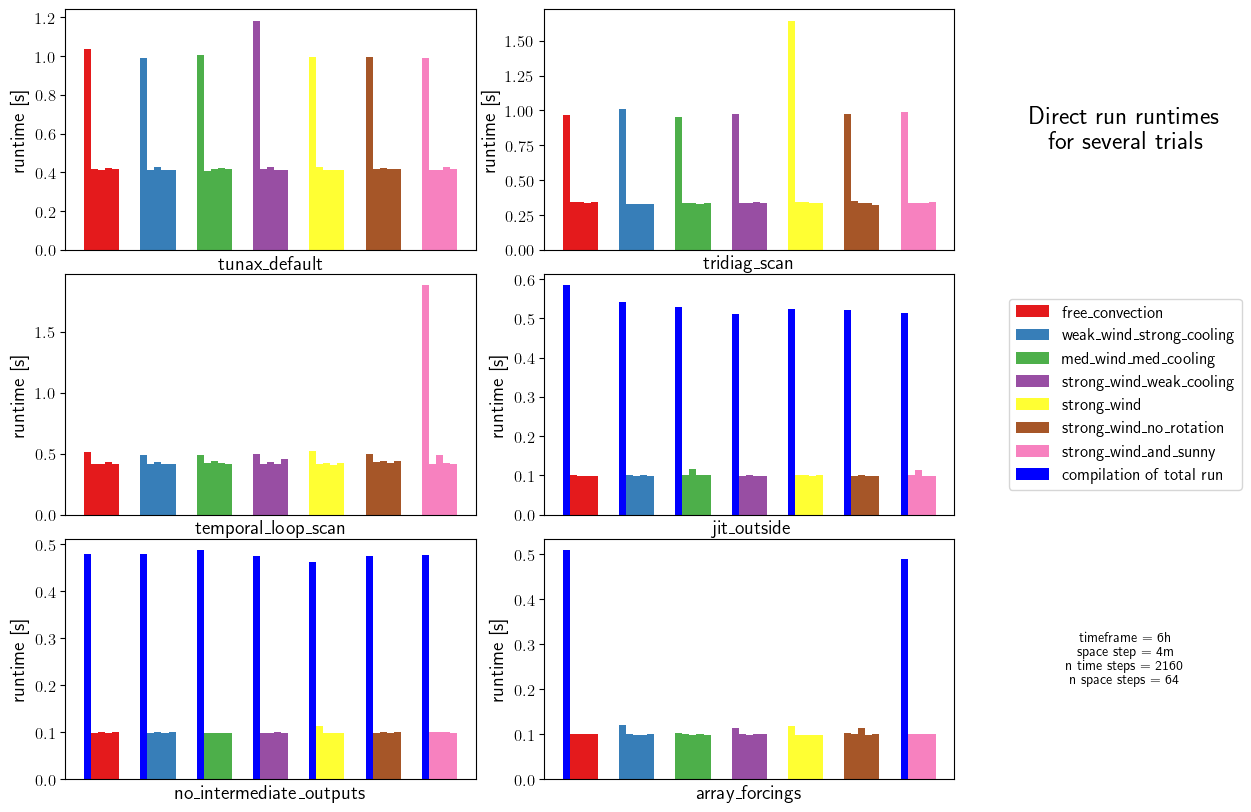

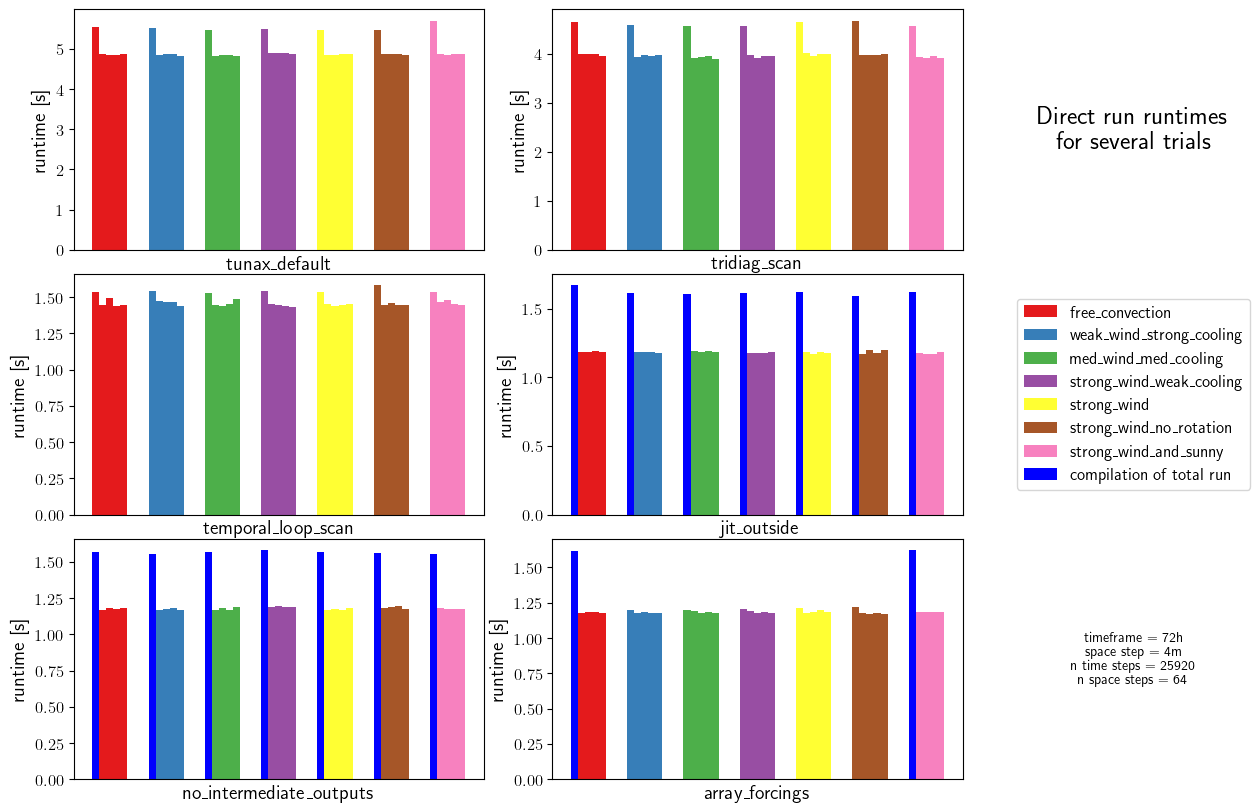

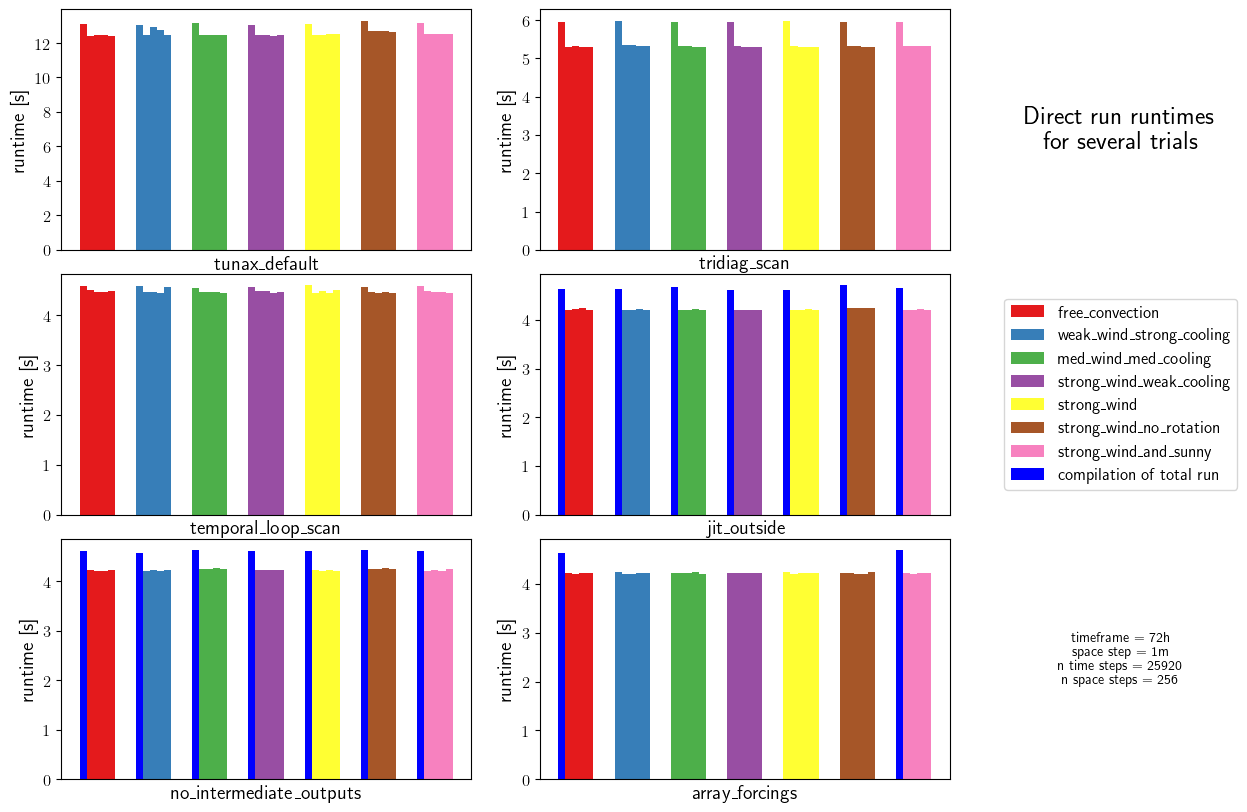

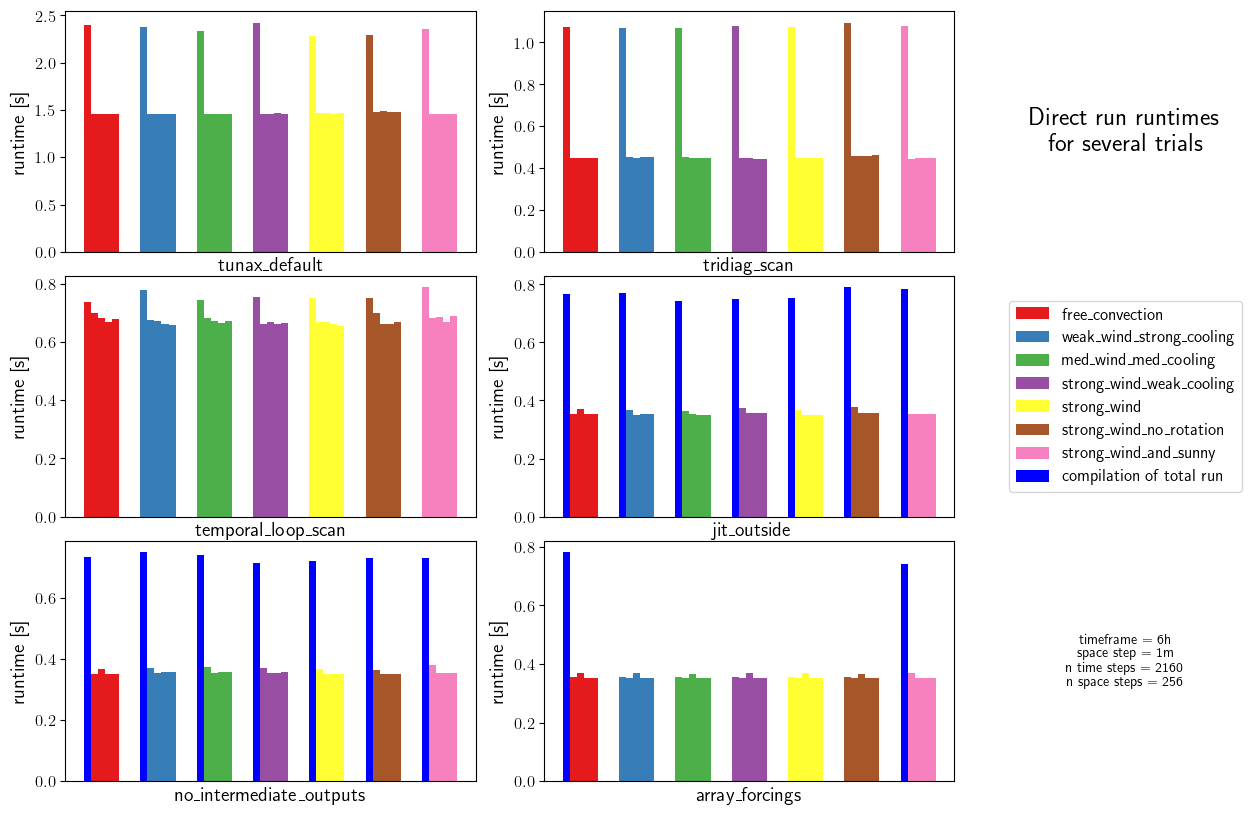

In [14]:
do_plot = True

if do_plot:
    plot_comp_direct(6, 4)
    plot_comp_direct(72, 4)
    plot_comp_direct(72, 1)
    plot_comp_direct(6, 1)

#### Analysis
- it works as espected : there is a compilation for every new forcing, and then the time of compiled version is smaller
- for the 3 first versions, it's not the total run which is compiled but smaller functions, it's not possible to get the confirmation of jax that there is a compilation here
- if the number of time steps increase, the ratio between the compilation time and the compiled time is smaller
- if the number of space steps increase, we have the same effect but less sensitive
- making the array as focings save some useless compilations (not a compilation by function (even if the values of the functions are the same), but a compilation by function signature)
- all the forcing have almost the sametime of execution : so we will to the time averaging on all the forcings and on the all the trials exept the first one

### Averaging
Here we average the runtimes on the 7 forcings and on the 4 runs that are not compiled.

In [15]:
runtime_means = {experience: {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for experience in direct_experiences.keys()}
ratios = {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES}
for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        for experience in direct_experiences.keys():
            runtime_means[experience][timeframe][space_step] = np.mean(runtimes_by_experience[experience][i_space_step, i_timeframe, :, 1:])
        ratios[timeframe][space_step] = runtime_means['tunax_default'][timeframe][space_step]/runtime_means['array_forcings'][timeframe][space_step]

### Method comparison
#### Plot

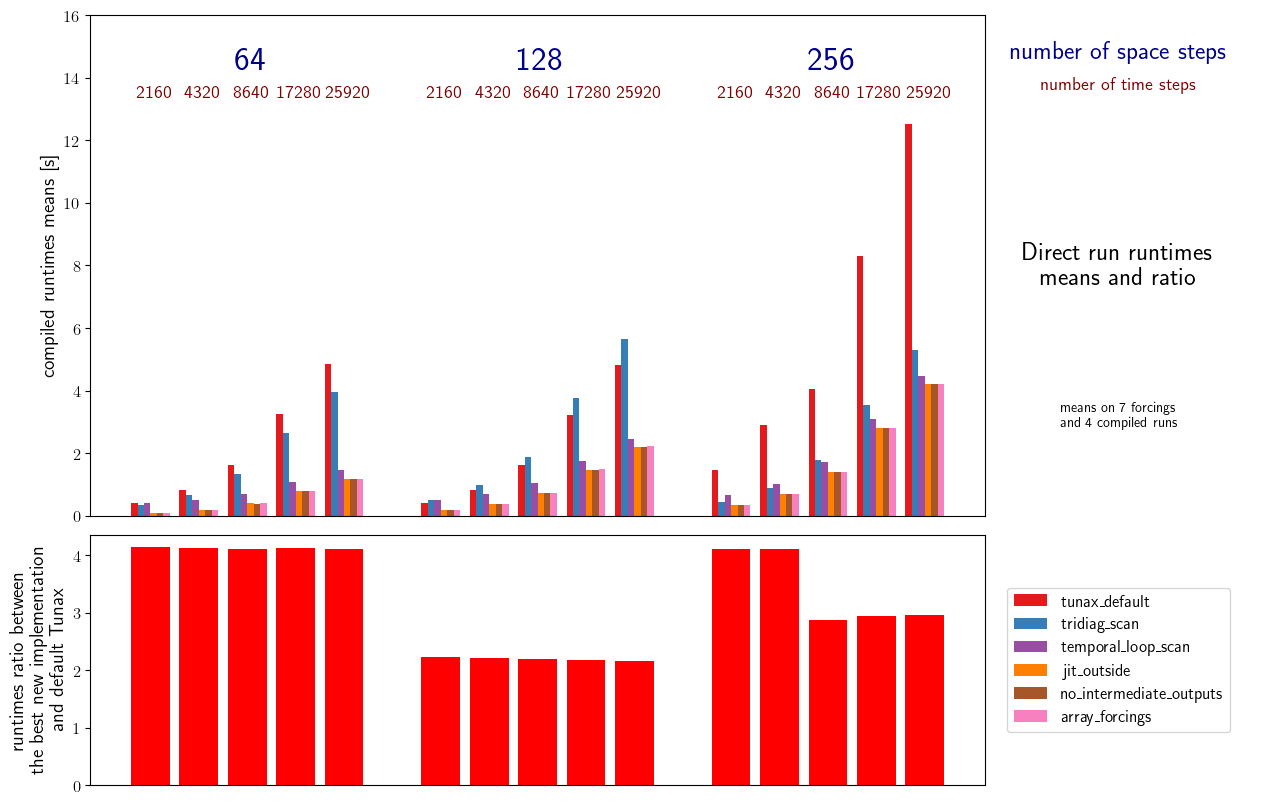

In [16]:
do_plot = True

if do_plot:
    # plot parameters
    cmap = mpl.colormaps['Set1']
    color_ratios = 'r'
    color_time_steps = 'maroon'
    color_space_steps = 'darkblue'

    # figure
    sp: subplot_2D_type = plt.subplots(2, 2, figsize=(15, 10), width_ratios=(1, .3), height_ratios=(1, .5))
    fig, axes_array = sp
    fig.subplots_adjust(wspace=0, hspace=.05)

    # axes
    ax_runtimes, ax_ratios, ax_title, ax_leg = axes_array[0][0], axes_array[1][0], axes_array[0][1], axes_array[1][1]

    # deletion of axis
    for ax in [ax_title, ax_leg]:
        ax.set_axis_off()

    # deletion of ticks
    for ax in [ax_runtimes, ax_ratios]:
        ax.set_xticks([])

    # plot parameters
    n_experiences = len(direct_experiences.keys())
    width_experience = 1
    width_timeframe = width_experience*(n_experiences+1.5)
    width_space_step = width_timeframe*(len(LES_TIMEFRAMES)+1)
    width_ratio = width_experience*(len(LES_TIMEFRAMES)+1)

    # plot for every experience, timeframe and space step
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_experience, experience in enumerate(direct_experiences.keys()):
                ax_runtimes.bar(
                    width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*i_experience,
                    runtime_means[experience][timeframe][space_step], width=width_experience, color=cmap(i_experience/n_experiences)
                )
            ax_ratios.bar(width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*n_experiences/2, ratios[timeframe][space_step], width=width_ratio, color=color_ratios)

    # text for problem sizes
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            ax_runtimes.text(
                width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*n_experiences/2,
                runtime_means['tunax_default'][72][1]+1, int(timeframe*3600/10.), va='center', ha='center', fontsize=13, color=color_time_steps
            )
        ax_runtimes.text(
            width_space_step*i_space_step + width_timeframe*(len(LES_TIMEFRAMES)-1)/2 + width_experience*n_experiences/2,
            runtime_means['tunax_default'][72][1]+2, int(256/space_step), va='center', ha='center', fontsize=24, color=color_space_steps
        )

    # limits
    ax_runtimes.set_ylim(0, 16)

    # legend
    for i_experience, experience in enumerate(direct_experiences.keys()):
        ax_leg.bar(0., 0., color=cmap(i_experience/n_experiences), label=experience)
    ax_leg.legend(loc='center')

    # axis names
    ax_runtimes.set_ylabel('compiled runtimes means [s]')
    ax_ratios.set_ylabel('runtimes ratio between\nthe best new implementation\nand default Tunax')

    # title and texts
    ax_title.text(.5, .925, 'number of space steps', va='center', ha='center', fontsize=18, color=color_space_steps)
    ax_title.text(.5, .86, 'number of time steps', va='center', ha='center', fontsize=13, color=color_time_steps)
    ax_title.text(.5, .5, 'Direct run runtimes\nmeans and ratio', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_title.text(.5, .2, 'means on 7 forcings\nand 4 compiled runs', ha='center', va='center', transform=ax_title.transAxes)

#### Analysis
- the runtimes are growing with the number of time steps, almost lineary for all experiences
- the runtimes are growing with the number of space steps, not lineary, or 64 and 128 vertical levels we have almost the same runtimes, probably because there is an offset cost for small grids
- puting `lax.scan` for the tridiagonal inversion helps a lot the runtimes for large number of vertical levels
- putting `lax.scan` for the temporal loop helps a lot the runtime, expecially for small sizes
- surprisingly, putting `jit` outside the temporal loop doesn't decrease a lot the runtimes
- we have the same observation when we use the function that doesn't do indermediate outputs or the functions that use array forcings instead of functionnal forcings
- bewteen the best version that we can have the the default *Tunax* runtimes, we have ratios between 2 and 5, it's a good gain but not that much, they will probably be way larger for the gradient
- I made this runtimes on a GPU on Bigfoot (UGA cluster), but the times are exploding, war larger than these ones. The amount of calculation are probably to small to be ran on a gpu, maybe for the gradient it will be different

# Gradients
## Define a loss function
With the RMSE of the last buoyancy state.

### For trajectories

In [17]:
def loss(parameters_array, fittable_parameters_set, model, obs, run_method_name):
    keps_params = fittable_parameters_set.fit_to_closure(parameters_array)
    run_method = getattr(model, run_method_name)
    traj_model = run_method(keps_params)
    traj_obs = obs.trajectory
    return jnp.sum((traj_model.b[-1, :]-traj_obs.b[-1, :])**2)

### For states
For the run method that don't compute the intermediate output but only the final state.

In [18]:
def loss_on_state(parameters_array, fittable_parameters_set, model, obs, run_method_name):
    keps_params = fittable_parameters_set.fit_to_closure(parameters_array)
    run_method = getattr(model, run_method_name)
    end_state, _, _ = run_method(keps_params)
    traj_obs = obs.trajectory
    return jnp.sum((end_state.b[:]-traj_obs.b[-1, :])**2)

## List of experiments tested
For the benchmark on the gradients, we will try several experiences with the new implementations.

### `tunax_default`
Here we use the function `grad` one with the default Tunax implementation (which contains some *jitted* functions inside the loop).

### `tridiag_scan`
Here it's the same but we just change the tridiagonal inversion function using `lax.scan`, there is still a `jit` on the step function as in Tunax default implementation.

### `fwd`
The same as before but using a forward gradient with `jacfwd`, we observe here the effect of the forward gradient with the tridiagonal inversion implemented with `lax.scan`. An other difference is that there is no inside `jit` (but it might changes nothing).

### `temporal_loop_scan`
Here we wrote the temporal integraction loop with `lax.scan`, the gradient is a classic reverse one, and there is no `jit` at all.

### `temporal_loop_scan_jit`
The same as before but we jitted the whole gradient function.

### `no_intermediate_outputs`
Here we wrote the temporal integraction loop with `lax.scan`, and we use a function that only returns the last state of the simulation, we can expect that it would be faster as JAX has less data to work with. The gradient is a classic reverse one, and there is no `jit` at all.

### `no_intermediate_outputs_jit`
The same as before but we jitted the whole gradient function.

### `array_forcings_jit`
Here is a new version of Tunax where we define the forcings of the tracers as arrays and not as functions, it should reduce the number of compilations when we use it in various cases. The whole gradient function is jitted.

### `fwd_grad_jit`
The same as before but using a forward gradient.


In [19]:
grad_experiences = {
    'tunax_default': {
        'name': 'tunax_default',
        'tunax_version': 'tunax',
        'run_method_name': 'compute_trajectory_with',
        'output': 'trajectory',
        'grad_type': 'rev',
        'jitted': False
    },
    'tridiag_scan': {
        'name': 'tridiag_scan',
        'tunax_version': 'tunax_new',
        'run_method_name': 'compute_trajectory_with',
        'output': 'trajectory',
        'grad_type': 'rev',
        'jitted': False
    },
    'fwd': {
        'name': 'fwd',
        'tunax_version': 'tunax_new',
        'run_method_name': 'compute_trajectory_with',
        'output': 'trajectory',
        'grad_type': 'fwd',
        'jitted': False        
    },
    'temporal_loop_scan': {
        'name': 'temporal_loop_scan',
        'tunax_version': 'tunax_new',
        'run_method_name': 'run',
        'output': 'trajectory',
        'grad_type': 'rev',
        'jitted': False        
    },
    'temporal_loop_scan_jit': {
        'name': 'temporal_loop_scan_jit',
        'tunax_version': 'tunax_new',
        'run_method_name': 'run',
        'output': 'trajectory',
        'grad_type': 'rev',
        'jitted': True        
    },
    'no_intermediate_outputs': {
        'name': 'no_intermediate_outputs',
        'tunax_version': 'tunax_new',
        'run_method_name': 'run_final_state',
        'output': 'final_state',
        'grad_type': 'rev',
        'jitted': False        
    },
    'no_intermediate_outputs_jit': {
        'name': 'no_intermediate_outputs_jit',
        'tunax_version': 'tunax_new',
        'run_method_name': 'run_final_state',
        'output': 'final_state',
        'grad_type': 'rev',
        'jitted': True        
    },
    'array_forcings_jit': {
        'name': 'array_forcings_jit',
        'tunax_version': 'tunax_new_case_tracable',
        'run_method_name': 'run',
        'output': 'trajectory',
        'grad_type': 'rev',
        'jitted': True        
    },
    'fwd_grad_jit': {
        'name': 'fwd_grad_jit',
        'tunax_version': 'tunax_new_case_tracable',
        'run_method_name': 'run',
        'output': 'trajectory',
        'grad_type': 'fwd',
        'jitted': True        
    }
}

## Benchmark function
Computing the gradients for every time step, forcing and timeframe would be too long. We write here a function that computes the gradient and the runtimes only for a specific set of these 3 parameters.

In [20]:
from tunax import SingleColumnModel as ModelOld
from tunax import Obs as ObsOld
from tunax import FittableParameter as FittableParameterOld
from tunax import FittableParametersSet as FittableParametersSetOld
from tunax_new import SingleColumnModel as ModelNew
from tunax_new import Obs as ObsNew
from tunax_new import FittableParameter as FittableParameterNew
from tunax_new import FittableParametersSet as FittableParametersSetNew
from tunax_new_case_tracable import SingleColumnModel as ModelNewTracable
from tunax_new_case_tracable import Obs as ObsNewTracable
from tunax_new_case_tracable import FittableParameter as FittableParameterNewTracable
from tunax_new_case_tracable import FittableParametersSet as FittableParametersSetNewTracable

def benchmark_grad(n_trials: int, dt: float, timeframe: int, space_step: int, forcing: str, experience: dict):
    # files
    runtimes = np.zeros(n_trials)
    compilations = np.zeros(n_trials, dtype=bool)
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience['name'])
    runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    compilations_path = os.path.join(output_path, f'compilations_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    os.makedirs(output_path, exist_ok=True)

    # select good classes
    tunax_version = experience['tunax_version']
    match tunax_version:
        case 'tunax':
            ObsClass = ObsOld
            FittableParameter = FittableParameterOld
            FittableParametersSet = FittableParametersSetOld
        case 'tunax_new':
            ObsClass = ObsNew
            FittableParameter = FittableParameterNew
            FittableParametersSet = FittableParametersSetNew
        case 'tunax_new_case_tracable':
            ObsClass = ObsNewTracable
            FittableParameter = FittableParameterNewTracable
            FittableParametersSet = FittableParametersSetNewTracable

    old_cache_size = 0
    jld2_filename = os.path.join(LES_PATH,f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
    obs = ObsClass.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

    # case corrections
    obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
    new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
    obs = eqx.tree_at(lambda t: t.case, obs, new_case)
    obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

    # passive tracer forcing
    omega_p = 1/obs.metadatas['pt_timescale']
    lambda_c = obs.metadatas['pt_width']
    zc = obs.metadatas['pt_depth']
    l_z = obs.trajectory.grid.hbot
    wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
    new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
    if tunax_version != 'tunax_new_case_tracable':
        new_case = replace(new_case, pt_forcing_type='constant')
    obs = eqx.tree_at(lambda t: t.case, obs, new_case)

    # sunny forcing
    if forcing == 'strong_wind_and_sunny':
        jb = obs.metadatas['sunny_flux']
        eps1 = 0.6
        lambda1 = 1.
        lambda2 = 16.
        wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
        new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
        if tunax_version != 'tunax_new_case_tracable':
            new_case = replace(new_case, b_forcing_type='constant')
        obs = eqx.tree_at(lambda t: t.case, obs, new_case)

    # model instance
    traj_wagner = obs.trajectory
    init_state = traj_wagner.extract_state(0)
    match tunax_version:
        case 'tunax':
            timeframe_h = float(traj_wagner.time[-1]/3600)
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            model = ModelOld(timeframe_h, dt, out_dt, init_state, obs.case, 'k-epsilon')
        case 'tunax_new':
            nt = int(timeframe*3600/dt)
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            p_out = int(out_dt/dt)
            model = ModelNew(nt, dt, p_out, init_state, obs.case, 'k-epsilon')
        case 'tunax_new_case_tracable':
            nt = int(timeframe*3600/dt)
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            p_out = int(out_dt/dt)
            model = ModelNewTracable(nt, dt, p_out, init_state, obs.case, 'k-epsilon')

    # fittable parameters
    c_eps1_par = FittableParameter(True, val=1.44)
    c_eps2_par = FittableParameter(True, val=1.92)
    c_eps3m_par = FittableParameter(True, val=.4)
    c_eps3p_par = FittableParameter(True, val=1.)
    sig_k_par = FittableParameter(True, val=1.)
    sig_eps_par = FittableParameter(True, val=1.3)
    coef_dico = {
        'c_eps1': c_eps1_par,
        'c_eps2': c_eps2_par,
        'c_eps3m': c_eps3m_par,
        'c_eps3p': c_eps3p_par,
        'sig_k': sig_k_par,
        'sig_eps': sig_eps_par
    }
    fit_params_set = FittableParametersSet(coef_dico, 'k-epsilon')
    parameters_array = fit_params_set.gen_init_val()

    # create gradient function
    if experience['output'] == 'trajectory':
        loss_fun = loss
    elif experience['output'] == 'final_state':
        loss_fun = loss_on_state
    if experience['grad_type'] == 'rev':
        grad_loss = grad(loss_fun, argnums=(0,))
    elif experience['grad_type'] == 'fwd':
        grad_loss = jacfwd(loss_fun, argnums=(0,))
    if experience['jitted']:
        grad_loss = jit(grad_loss, static_argnames=('fittable_parameters_set', 'run_method_name'))

    # run gradient for several trials
    run_method_name = experience['run_method_name']
    for i_trial in tqdm(range(n_trials), desc=f'trials for {run_method_name}', leave=False):
        # run the gradient
        start_time = tt()
        block_until_ready(grad_loss(parameters_array, fit_params_set, model, obs, run_method_name))
        runtimes[i_trial] = tt() - start_time

        # record the compilation
        if experience['jitted']:
            if grad_loss._cache_size() > old_cache_size:
                compilations[i_trial] = True
                old_cache_size = grad_loss._cache_size()

    # write the times and the cache size
    np.save(runtimes_path, runtimes)
    np.save(compilations_path, compilations)

### Run for one forcing
Here we compute the benchmark for all the timeframe and space step values but only for one forcing (we saw earlier that all the 7 forcings take almost the same cost of calculation for direct model, we can guess that it would be the same for the gradient).

In [21]:
do_run = False

n_trials = 4
dt = 10.
forcing = 'free_convection'

if do_run:
    pbar= tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES), desc='simulation')
    for timeframe in LES_TIMEFRAMES:
        for space_step in LES_SPACE_STEPS:
            for experience in grad_experiences.values():
                benchmark_grad(n_trials, dt, timeframe, space_step, forcing, experience)
            pbar.update(1)
    pbar.close()

The run took 5 hours on a Macbook Pro with an Apple M3Pro CPU.

## Runtimes
### Load datas

In [22]:
runtimes_by_experience = {}
compilations_by_experience = {}
for experience in grad_experiences.keys():
    runtimes = np.zeros((len(LES_SPACE_STEPS), len(LES_TIMEFRAMES), n_trials))
    compilations = np.zeros((len(LES_SPACE_STEPS), len(LES_TIMEFRAMES), n_trials))
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
            compilations_path = os.path.join(output_path, f'compilations_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
            runtimes[i_space_step, i_timeframe, :] = np.load(runtimes_path)
            compilations[i_space_step, i_timeframe, :] = np.load(compilations_path)
    runtimes_by_experience[experience] = runtimes
    compilations_by_experience[experience] = compilations

### Compilation effect
#### Plot function

In [23]:
def plot_comp_grad(timeframe: int, space_step: int):
    # plot parameters
    cmap = mpl.colormaps['Set1']
    color_comp = 'b'

    # figure
    sp: subplot_1D_type = plt.subplots(1, 2, figsize=(10, 5), width_ratios=(1, .4))
    _, ax_array = sp
    fig.subplots_adjust(hspace=0)
    ax, ax_title = ax_array[0], ax_array[1]

    # deletion of the ticks and of the axis
    ax_title.set_axis_off()
    ax.set_xticks([])

    # bar parameters
    width_trial = 1
    n_experience = len(grad_experiences.keys())
    width_experience = width_trial*(n_experience+1)
    i_timeframe = LES_TIMEFRAMES.index(timeframe)
    i_space_step = LES_SPACE_STEPS.index(space_step)

    # data
    
    # plot
    for i_trial in range(n_trials):
        for i_experience, experience in enumerate(grad_experiences.keys()):
            runtimes = runtimes_by_experience[experience]
            compilations = compilations_by_experience[experience]
            if compilations[i_space_step, i_timeframe, i_trial]:
                color = color_comp
            else:
                color = cmap(i_experience/n_experience)
            ax.bar(width_experience*i_experience + width_trial*i_trial, runtimes[i_space_step, i_timeframe, i_trial], width=width_trial, color=color)
        
    # legend
    for i_experience, experience in enumerate(grad_experiences.keys()):
        ax_title.bar(0., 0., color=cmap(i_experience/n_experience), label=experience)
    ax_title.bar(0, 0, width=width_trial, color=color_comp, label='compilation of total run')
    ax_title.legend()

    # nom des axes
    ax.set_ylabel('runtime [s]')

    # titre
    ax_title.text(.5, .25, 'Gradient run runtimes\nfor several trials', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_title.text(.5, .1, f'timeframe = {timeframe}h\nspace step = {space_step}m\nn time steps = {int(timeframe*3600/10)}\nn space steps = {int(256/space_step)}', ha='center', va='center', transform=ax_title.transAxes)

#### Plot for extreme cases

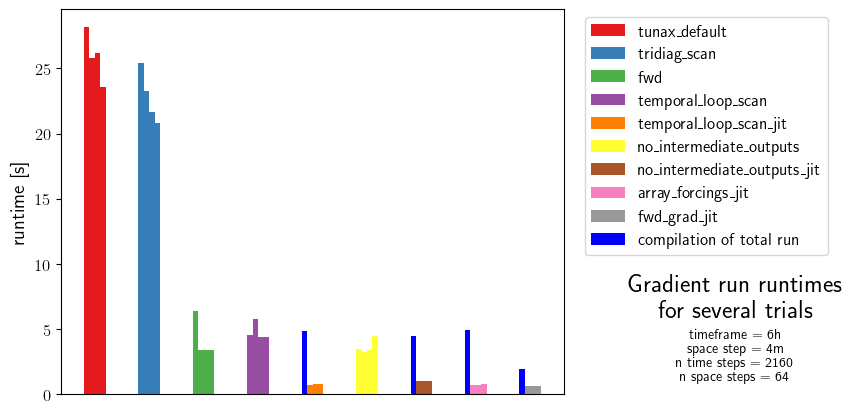

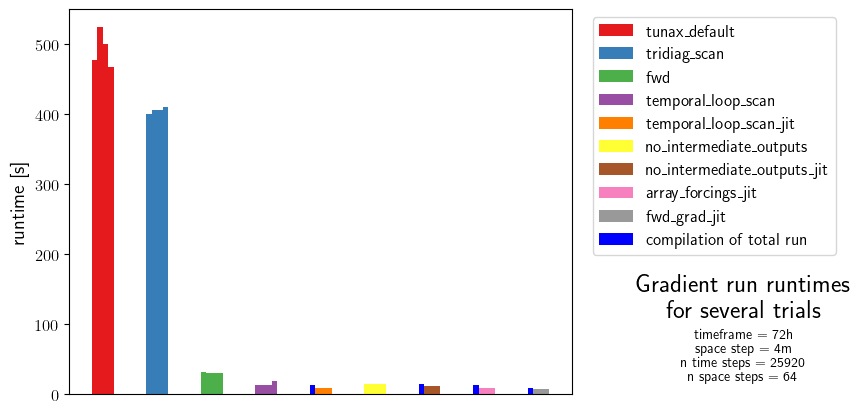

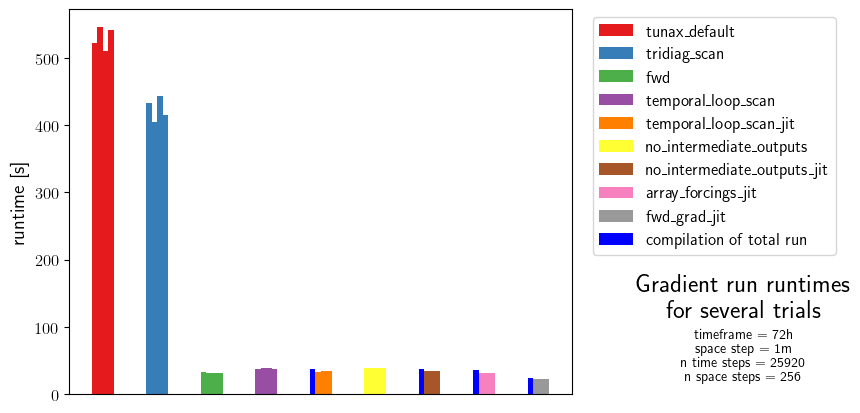

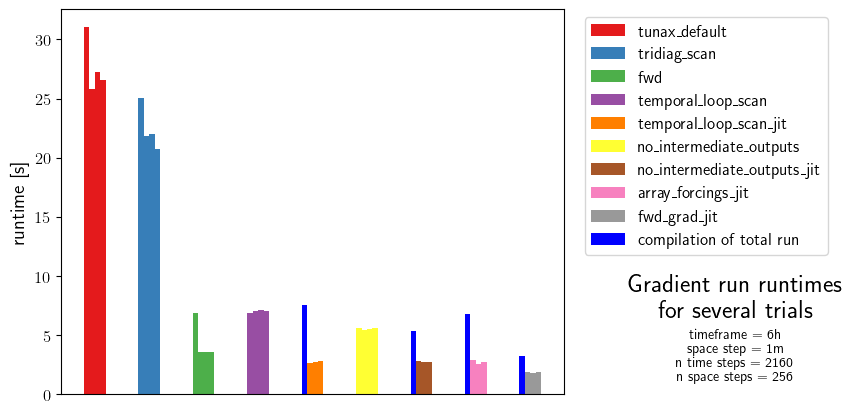

In [24]:
do_plot = True

if do_plot:
    plot_comp_grad(6, 4)
    plot_comp_grad(72, 4)
    plot_comp_grad(72, 1)
    plot_comp_grad(6, 1)

#### Analysis
- here we can wheck that the compilation occurs for the first execution of the run function as expected.
- as for the direct runs, we notice that the time of compilation is higher in comparison of the runtimes of the compiled versions when the timeframe is higher
- we can also notice that the compilation with jit is more efficient when we have a small number of time steps

### Averaging
Here we average for the 3 runs for each experience.

In [25]:
runtime_means = {experience: {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for experience in grad_experiences.keys()}
ratios = {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES}
for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        for experience in grad_experiences.keys():
            runtime_means[experience][timeframe][space_step] = np.mean(runtimes_by_experience[experience][i_space_step, i_timeframe, 1:])
        ratios[timeframe][space_step] = runtime_means['tunax_default'][timeframe][space_step]/runtime_means['fwd_grad_jit'][timeframe][space_step]

### Method comparison
#### Plot

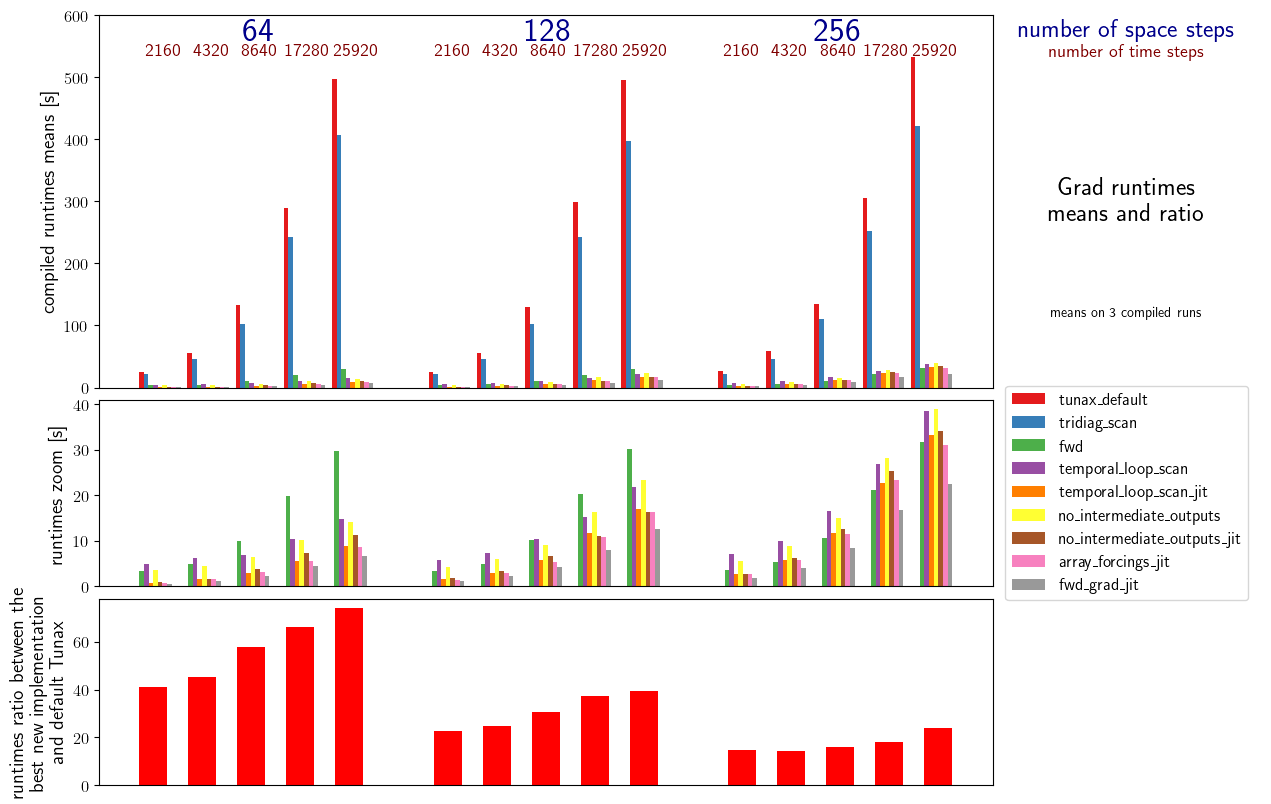

In [26]:
do_plot = True

if do_plot:
    # plot parameters
    cmap = mpl.colormaps['Set1']
    color_ratios = 'r'
    color_time_steps = 'maroon'
    color_space_steps = 'darkblue'

    # figure
    sp: subplot_2D_type = plt.subplots(3, 2, figsize=(15, 10), width_ratios=(1, .3), height_ratios=(1, .5, .5))
    fig, axes_array = sp
    fig.subplots_adjust(wspace=0, hspace=.05)

    # axes
    ax_runtimes, ax_runtimes_zoom, ax_ratios, ax_title, ax_leg, ax_empty = axes_array[0][0], axes_array[1][0], axes_array[2][0], axes_array[0][1], axes_array[1][1], axes_array[2][1]

    # deletion of axis
    for ax in [ax_title, ax_leg, ax_empty]:
        ax.set_axis_off()

    # deletion of ticks
    for ax in [ax_runtimes, ax_runtimes_zoom, ax_ratios]:
        ax.set_xticks([])

    # plot parameters
    n_experiences = len(grad_experiences.keys())
    width_experience = 1
    width_timeframe = width_experience*(n_experiences+1.5)
    width_space_step = width_timeframe*(len(LES_TIMEFRAMES)+1)
    width_ratio = width_experience*(len(LES_TIMEFRAMES)+1)

    # plot for every experience, timeframe and space step
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_experience, experience in enumerate(grad_experiences.keys()):
                ax_runtimes.bar(
                    width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*i_experience,
                    runtime_means[experience][timeframe][space_step], width=width_experience, color=cmap(i_experience/n_experiences)
                )
                if i_experience > 1:
                    ax_runtimes_zoom.bar(
                    width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*i_experience,
                    runtime_means[experience][timeframe][space_step], width=width_experience, color=cmap(i_experience/n_experiences)
                )
            ax_ratios.bar(width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*n_experiences/2, ratios[timeframe][space_step], width=width_ratio, color=color_ratios)

    # text for problem sizes
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            ax_runtimes.text(
                width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*n_experiences/2,
                runtime_means['tunax_default'][72][1]+10, int(timeframe*3600/10.), va='center', ha='center', fontsize=13, color=color_time_steps
            )
        ax_runtimes.text(
            width_space_step*i_space_step + width_timeframe*(len(LES_TIMEFRAMES)-1)/2 + width_experience*n_experiences/2,
            runtime_means['tunax_default'][72][1]+40, int(256/space_step), va='center', ha='center', fontsize=24, color=color_space_steps
        )

    # limits
    ax_runtimes.set_ylim(0, 600)

    # legend
    for i_experience, experience in enumerate(grad_experiences.keys()):
        ax_leg.bar(0., 0., color=cmap(i_experience/n_experiences), label=experience)
    ax_leg.legend(loc='center')

    # axis names
    ax_runtimes.set_ylabel('compiled runtimes means [s]')
    ax_runtimes_zoom.set_ylabel('runtimes zoom [s]')
    ax_ratios.set_ylabel('runtimes ratio between the\nbest new implementation\nand default Tunax')

    # title and texts
    ax_title.text(.5, .96, 'number of space steps', va='center', ha='center', fontsize=18, color=color_space_steps)
    ax_title.text(.5, .9, 'number of time steps', va='center', ha='center', fontsize=13, color=color_time_steps)
    ax_title.text(.5, .5, 'Grad runtimes\nmeans and ratio', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_title.text(.5, .2, 'means on 3 compiled runs', ha='center', va='center', transform=ax_title.transAxes)

#### Analysis
- puting `lax.scan` on the tridiagonal inversion has an effect but not so big
- using at least forward gradient or `lax.scan` on the temporal loop has a huge effect
- the effect of the jitidied versions is visible, mainly for the small sizes
- using the version with no intermediate outputs doesn't change the runtimes, in fact their are slightly highers
- using array forcing doesn't change much either (but it stills have an effect on the number of compilations)
- the best version is clearly to use the forward gradient and jit
- the ratio of time that we get with the modifications increase with the number of time steps (otpimisation of lax), but decrease with the number of space steps
- the ratios are between 20 and 70

# Devices comparison
## Direct runtimes
### Load data and averaging
Here we compare the runtimes for different devices.

In [27]:
devices_list = ['tesla_V100', 'apple_M3pro', 'dahu']
runtimes_means = {}
for experience in direct_experiences.keys():
    means_by_device = {device: {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for device in devices_list}
    for device in devices_list:
        runtimes_file_name = f'runtimes_{device}.npy'
        runtimes_path = os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience, runtimes_file_name)
        if os.path.exists(runtimes_path):
            runtimes = np.load(runtimes_path)
            for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
                for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
                    means_by_device[device][timeframe][space_step] = np.mean(runtimes[i_space_step, i_timeframe, :, 1:])
    runtimes_means[experience] = means_by_device

### Plot

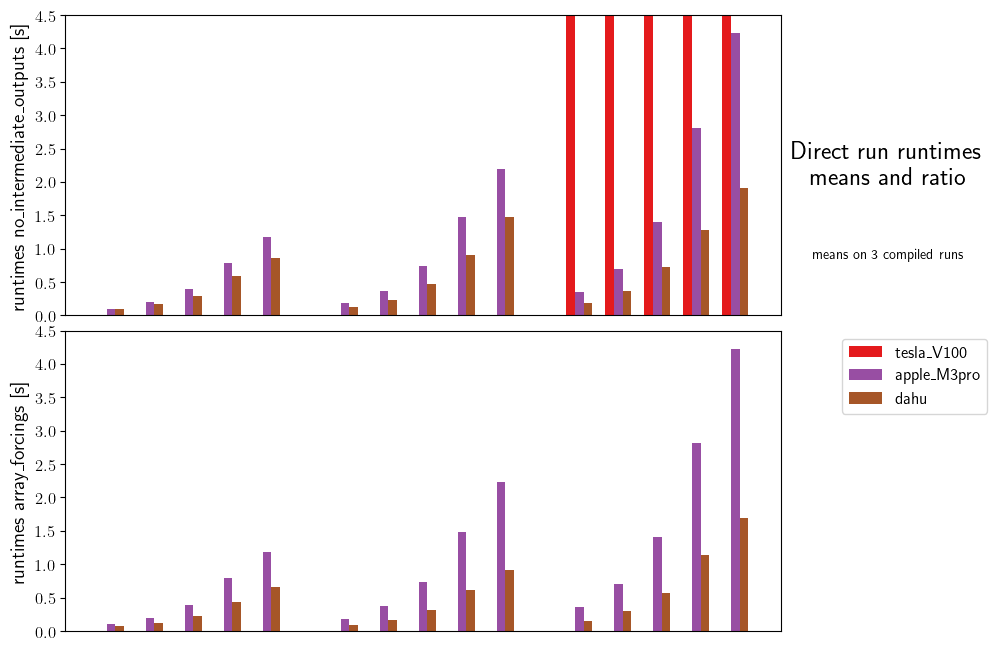

In [28]:
do_plot = True

# plot parameters
experiences_list = ['no_intermediate_outputs', 'array_forcings']
y_maxs = {
    'no_intermediate_outputs': 4.5,
    'array_forcings': 4.5
}

if do_plot:
    # plot parameters
    cmap = mpl.colormaps['Set1']

    # figure
    sp: subplot_2D_type = plt.subplots(2, 2, figsize=(12, 8), height_ratios=(1, 1), width_ratios=(1, .3))
    fig, axes_array = sp
    fig.subplots_adjust(wspace=0, hspace=.05)

    # axes
    axes_by_experience = {experience: axes_array[i_experience][0] for i_experience, experience in enumerate(experiences_list)}
    ax_title, ax_leg = axes_array[0][1], axes_array[1][1]

    # deletion of axis
    ax_title.set_axis_off()
    ax_leg.set_axis_off()

    # deletion of ticks
    for ax in axes_by_experience.values():
        ax.set_xticks([])

    # plot parameters
    width_device = 1
    width_timeframe = width_device*(len(devices_list)+1.5)
    width_space_step = width_timeframe*(len(LES_TIMEFRAMES)+1)

    # plot for every experience, timeframe and space step
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_device, device in enumerate(devices_list):
                for experience, ax in axes_by_experience.items():
                    ax.bar(
                        width_space_step*i_space_step + width_timeframe*i_timeframe + width_device*i_device,
                        runtimes_means[experience][device][timeframe][space_step], width=width_device, color=cmap(i_device/len(devices_list))
                    )

    # limits
    for experience, ax in axes_by_experience.items():
        ax.set_ylim(0, y_maxs[experience])

    # legend
    for i_device, device in enumerate(devices_list):
        ax_leg.bar(0., 0., color=cmap(i_device/len(devices_list)), label=device)
    ax_leg.legend()

    # axis names
    for experience, ax in axes_by_experience.items():
        ax.set_ylabel(f'runtimes {experience} [s]')

    # title and texts
    ax_title.text(.5, .5, 'Direct run runtimes\nmeans and ratio', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_title.text(.5, .2, 'means on 3 compiled runs', ha='center', va='center', transform=ax_title.transAxes)

### Analysis
The runtimes of the GPU V100 could be computed only for one 5 cases, and the runtimes are very huge as we can see. It is because the problem doesn't have a large dimenssion and the computations can't be vectorize a lot. Otherwise, running on the cluster of CPU Dahu from Gridcad is around 2 times faster that on a laptop.

## Gradient runtimes
### Load data and averaging

In [29]:
devices_list = ['tesla_V100', 'apple_M3pro', 'dahu']
runtimes_means = {}
forcing = 'free_convection'

for experience in grad_experiences.keys():
    means_by_device = {device: {timeframe: {space_step: 0 for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for device in devices_list}
    for device in devices_list:
        output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
        for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
            for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
                runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{device}.npy')
                if os.path.exists(runtimes_path):
                    runtimes = np.load(runtimes_path)
                    means_by_device[device][timeframe][space_step] = np.mean(runtimes[1:])
    runtimes_means[experience] = means_by_device

### Plot

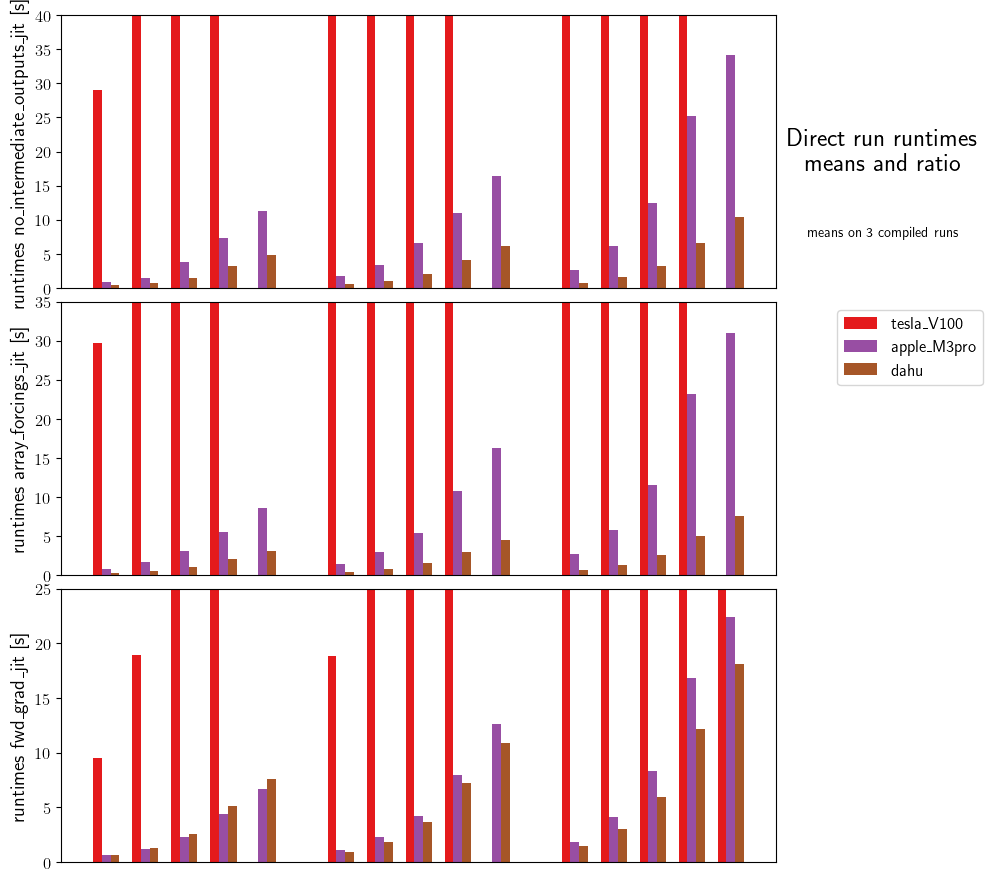

In [30]:
do_plot = True

# plot parameters
experiences_list = ['no_intermediate_outputs_jit', 'array_forcings_jit', 'fwd_grad_jit']
y_maxs = {
    'no_intermediate_outputs_jit': 40,
    'array_forcings_jit': 35,
    'fwd_grad_jit': 25
}

if do_plot:
    # plot parameters
    cmap = mpl.colormaps['Set1']

    # figure
    sp: subplot_2D_type = plt.subplots(3, 2, figsize=(12, 11), height_ratios=(1, 1, 1), width_ratios=(1, .3))
    fig, axes_array = sp
    fig.subplots_adjust(wspace=0, hspace=.05)

    # axes
    axes_by_experience = {experience: axes_array[i_experience][0] for i_experience, experience in enumerate(experiences_list)}
    ax_title, ax_leg, ax_empty = axes_array[0][1], axes_array[1][1], axes_array[2][1]

    # deletion of axis
    for ax in [ax_title, ax_leg, ax_empty]:
        ax.set_axis_off()

    # deletion of ticks
    for ax in axes_by_experience.values():
        ax.set_xticks([])

    # plot parameters
    width_device = 1
    width_timeframe = width_device*(len(devices_list)+1.5)
    width_space_step = width_timeframe*(len(LES_TIMEFRAMES)+1)

    # plot for every experience, timeframe and space step
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_device, device in enumerate(devices_list):
                for experience, ax in axes_by_experience.items():
                    ax.bar(
                        width_space_step*i_space_step + width_timeframe*i_timeframe + width_device*i_device,
                        runtimes_means[experience][device][timeframe][space_step], width=width_device, color=cmap(i_device/len(devices_list))
                    )

    # limits
    for experience, ax in axes_by_experience.items():
        ax.set_ylim(0, y_maxs[experience])

    # legend
    for i_device, device in enumerate(devices_list):
        ax_leg.bar(0., 0., color=cmap(i_device/len(devices_list)), label=device)
    ax_leg.legend()

    # axis names
    for experience, ax in axes_by_experience.items():
        ax.set_ylabel(f'runtimes {experience} [s]')

    # title and texts
    ax_title.text(.5, .5, 'Direct run runtimes\nmeans and ratio', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_title.text(.5, .2, 'means on 3 compiled runs', ha='center', va='center', transform=ax_title.transAxes)

### Analysis
- we have the same issue than for the direct model for the GPU V100, but more of the runs could be computed in a decent time : the complexity of the gradient function might reduce the difference between CPU and GPU and make the GPU a bit more worth it
- again the CPU of the cluster Dahu is better than the laptop, but the difference is not so large for the best computing method
- in fact the cluster is better with the reverse gradient than with the forward gradient, which is not the case for the laptop

# Conclusion
After this work we can decide for the next Tunax's release the following things :
- for the model, we keep the version that use array forcings (to minimise the number of compilations) and with the tridiagonal inversion and the integration loop written with `lax.scan`
- to run direct models we will put the `jit` totally outside of the model
- to run gradients (and calibrations) we will use forward gradient `grad` if we use a cluster of CPUs
- to run gradients (and calibrations) we will use forward gradient `jacfwd` if we use a laptop
- we don't use GPUs exept if we achieve to vetctorise many models at the same time
- finally we are not obliged to implement a run method which just give the last state, obsviously this methode doesn't decrease the runtimes